## Classification with BERT

Here, 

1. We will prepare the corpus for BERT (Input features)
2. Fine tune a BERT-like model (DistilBERT) using transfer learning
3. And classify our documents into their final categories. 
4. Then score the unlabeled cases

In [1]:
import csv
import numpy as np
import torch
import torch.nn as nn

from loguru import logger
from multiprocessing import Pool, cpu_count
from pathlib import Path
from transformers import DistilBertConfig, DistilBertForSequenceClassification, DistilBertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup

from sklearn.metrics import matthews_corrcoef, confusion_matrix, f1_score
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from tqdm.notebook import tqdm, trange

## 1. Setup and Utility Functions

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class InputExample():
    """A single training/test example for simple sequence classification."""
    def __init__(self, guid, text_a, text_b=None, label=None):
        """Construct an InputExample.

        Args:
            guid: Unique id for the example.
            text_a: string. The untokenized text of the first sequence.
            text_b: (Optional) string. The untokenized text of the second
            sequence. Only must be specified for sequence pair tasks.
            label: (Optional) string. The label of the example. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

class InputFeatures(object):
    """
    A single set of features of data.
    Args:
        input_ids: Indices of input sequence tokens in the vocabulary.
        attention_mask: Mask to avoid performing attention on padding token indices.
            Mask values selected in ``[0, 1]``:
            Usually  ``1`` for tokens that are NOT MASKED, ``0`` for MASKED (padded) tokens.
        token_type_ids: Segment token indices to indicate first and second portions of the inputs.
        label: Label corresponding to the input
    """

    def __init__(self, input_ids, attention_mask=None, token_type_ids=None, label=None):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.token_type_ids = token_type_ids
        self.label = label

def convert_example_to_feature(example_row):
    """
    Loads a data file into a list of ``InputFeatures``
    Args:
        example_row mappings:
        examples: List of ``InputExamples`` or ``tf.data.Dataset`` containing the examples.
        tokenizer: Instance of a tokenizer that will tokenize the examples
        max_seq_length: Maximum example length
        label_list: List of labels.
        output_mode: String indicating the output mode. Either ``regression`` or ``classification``
        pad_on_left: If set to ``True``, the examples will be padded on the left rather than on the
                    right (default)
        pad_token: Padding token
        pad_token_segment_id: The segment ID for the padding token (It is usually 0,
                              but can vary such as for XLNet where it is 4)
        mask_padding_with_zero: If set to ``True``, the attention mask will be filled by ``1``
            for actual values and by ``0`` for padded values. If set to ``False``, inverts it (``1``
            for padded values, ``0`` for actual values)
    Returns:
        If the ``examples`` input is a ``tf.data.Dataset``, will return a ``tf.data.Dataset``
        containing the task-specific features. If the input is a list of ``InputExamples``, will return
        a list of task-specific ``InputFeatures`` which can be fed to the model.
    """
    # return example_row
    example, label_map, max_seq_length, tokenizer, output_mode, \
    pad_on_left, pad_token, pad_token_segment_id, mask_padding_with_zero = example_row

    inputs = tokenizer.encode_plus(example.text_a,
                                   example.text_b,
                                   add_special_tokens=True,
                                   max_length=max_seq_length)

    input_ids, token_type_ids = inputs["input_ids"], inputs["token_type_ids"]

    # The mask has 1 for real tokens and 0 for padding tokens. Only real tokens are attended to.
    attention_mask = [1 if mask_padding_with_zero else 0] * len(input_ids)
    # Zero-pad up to the sequence length.
    padding_length = max_seq_length - len(input_ids)

    if pad_on_left:
        input_ids = ([pad_token] * padding_length) + input_ids
        attention_mask = ([0 if mask_padding_with_zero else 1] * padding_length) + attention_mask
        token_type_ids = ([pad_token_segment_id] * padding_length) + token_type_ids
    else:
        input_ids = input_ids + ([pad_token] * padding_length)
        attention_mask = attention_mask + ([0 if mask_padding_with_zero else 1] * padding_length)
        token_type_ids = token_type_ids + ([pad_token_segment_id] * padding_length)

    if example.label != "":
        if output_mode == "classification":
            label_id = label_map[example.label]
        elif output_mode == "regression":
            label_id = float(example.label)
        else:
            raise KeyError(output_mode)

        return InputFeatures(input_ids=input_ids,
                             attention_mask=attention_mask,
                             token_type_ids=token_type_ids,
                             label=label_id)
    else:
        return InputFeatures(input_ids=input_ids,
                             attention_mask=attention_mask,
                             token_type_ids=token_type_ids, 
                            )
    

In [4]:
class DataProcessor(object):
    """Base class for data converters for sequence classification data sets."""

    def __init__(self, labels=None):
        self._labels=labels

    def get_train_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the train set."""
        raise NotImplementedError()

    def get_test_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the dev set."""
        raise NotImplementedError()

    def set_labels(self, labs):
        self._labels = labs

    def get_labels(self):
        """Gets the list of labels for this data set."""
        raise NotImplementedError()

    @classmethod
    def _read_tsv(cls, input_file, quotechar=None):
        """Reads a tab separated value file."""
        with open(input_file, "r", encoding="utf-8") as f:
            reader = csv.reader(f, delimiter="\t", quotechar=quotechar)
            lines = []
            for line in reader:
                lines.append(line)
            return lines

In [5]:
class ClassificationProcessor(DataProcessor):
    """Processor for multi-class classification dataset"""

    def get_train_examples(self, data_dir):
        """See base class."""
        return self._create_examples(self._read_tsv(data_dir / 'train.tsv'), "train")

    def get_dev_examples(self, data_dir):
        """See base class."""
        return self._create_examples(self._read_tsv(data_dir / 'dev.tsv'), "dev")
    
    def get_test_examples(self, data_dir):
        """See base class."""
        return self._create_examples(self._read_tsv(data_dir / 'test.tsv'), "test")

    def get_labels(self):
        """See base class."""
        return self._labels

    def _create_examples(self, lines, set_type):
        """Creates examples for the training and dev sets."""
        examples = []
        for (_, line) in enumerate(lines):
            guid = "%s-%s" % (set_type, line[0])
            text_a = line[3]
            label = line[1]
            examples.append(InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
        return examples

## 2. Hyperparameter Settings For Training

In [6]:
# Data Folder
data_folder = Path.home() / 'Data' / 'cc_news'
model_input_folder = data_folder / 'model_input'

In [7]:
# Get your train examples
processor = ClassificationProcessor()

In [8]:
# Set labels 
labels = ['politics', 'sports', 'business_economy', 'world', 'entertainment']
num_labels = len(labels)
# Let the processor know what the labels are
processor.set_labels(labels)

# Create Label to Index Map 
label_map = {label: i for i, label in enumerate(labels)}

In [18]:
# Set model Hyper Parameters
max_seq_length = 256
train_batch_size = 32
gradient_accumulation_steps = 2
num_train_epochs = 4
learning_rate = 2e-5

output_mode = 'classification'
bert_model = 'distilbert-base-uncased'
cache_dir = 'cache/'
bmodel_type = 'distilbert'

processor_count = cpu_count() - 1

## 3. Convert text to Input Features for BERT

In [10]:
# Load Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained(bert_model, do_lower_case=True)

In [11]:
train_examples = processor.get_train_examples(model_input_folder)

In [12]:
pad_on_the_left = False
pad_token = tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0]
pad_token_segment_id = 0
mask_padding_with_zero = True
examples = [(example, label_map, max_seq_length, tokenizer, output_mode, pad_on_the_left,
                     pad_token, pad_token_segment_id, mask_padding_with_zero)
                    for example in train_examples]

In [13]:
with Pool(processor_count) as proc:
    features = list(tqdm(proc.imap(convert_example_to_feature, examples), total=len(train_examples)))

In [35]:
def convert_to_tensors(features, data_type=None):
    """Get your Feature Vectords into the tensors."""
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_attention_masks = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
    all_token_type_ids = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)
    if data_type != "test":
        all_labels = torch.tensor([f.label for f in features if f.label !=""], dtype=torch.long)
        dataset = TensorDataset(all_input_ids, all_attention_masks, all_token_type_ids, all_labels)
    else:
        dataset = TensorDataset(all_input_ids, all_attention_masks, all_token_type_ids)
    return dataset

In [15]:
num_training_steps = int(len(features) / train_batch_size / gradient_accumulation_steps) * num_train_epochs

In [16]:
train_data = convert_to_tensors(features)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=train_batch_size)

## 4. Set Model for Training

In [17]:
model = DistilBertForSequenceClassification.from_pretrained(bert_model, cache_dir=cache_dir, num_labels=num_labels)

In [19]:
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (dropout): Dropout(p=0.1, inplace=False)
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
         

In [20]:
param_optimizer = model.named_parameters()
no_decay = ['bias', 'LayerNorm.weight']

optimizer_grouped_parameters = [{'params':
                                 [p for n, p in param_optimizer
                                  if not any(nd in n for nd in no_decay)],
                                 'weight_decay': 0.00},
                                {'params':
                                 [p for n, p in param_optimizer
                                  if any(nd in n for nd in no_decay)],
                                 'weight_decay': 0.0}]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, correct_bias=False)

num_warmup_steps = int(num_training_steps * 0.1)
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=num_warmup_steps,
                                            num_training_steps=num_training_steps)

## 5. Training

In [21]:
global_step = 0
nb_tr_steps = 0
tr_loss = 0
train_loss_set = []
model.zero_grad()

In [23]:
logger.info("***** Running training...")
logger.info(f"  Num examples = {len(train_data)}")
logger.info(f"  Batch size = {train_batch_size}")
logger.info(f"  Num steps = {num_training_steps}")
for _ in trange(int(num_train_epochs), desc="Epoch"):

    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    # Iterating through batches
    for step, batch in enumerate(tqdm(train_dataloader, desc="Iteration")):
        # Set our model to training mode (as opposed to evaluation mode)
        model.train()
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[3]}\

        if model_type != 'distilbert':
            inputs['token_type_ids'] = batch[2] if model_type in ['bert', 'xlnet'] else None

        outputs = model(**inputs)
        loss = outputs[0]
        train_loss_set.append(loss)

        if gradient_accumulation_steps > 1:
            loss = loss / gradient_accumulation_steps

        
        
        loss.backward()
        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += inputs["input_ids"].size(0)
        nb_tr_steps += 1

        if (step + 1) % gradient_accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

            print("\r%f" % loss, end='')

            optimizer.step()
            scheduler.step()
            model.zero_grad()
            global_step += 1

logger.info("******* END OF TRAINING ******")
logger.info(f"Train loss: {tr_loss/nb_tr_steps}")

0.795290


0.093327


0.007423


0.032561

2020-01-10 13:07:19.183 | INFO     | __main__:<module>:44 - ******* END OF TRAINING ******
2020-01-10 13:07:19.183 | INFO     | __main__:<module>:45 - Train loss: 0.059022492138095774


0.021451



## 6. Evaluation of the Dev Set

In [24]:
# Evaluation
dev_examples = processor.get_dev_examples(model_input_folder)
examples = [(example, label_map, max_seq_length, tokenizer, output_mode, pad_on_the_left,
                     pad_token, pad_token_segment_id, mask_padding_with_zero)
                    for example in dev_examples]

In [25]:
with Pool(processor_count) as proc:
    features = list(tqdm(proc.imap(convert_example_to_feature, examples), total=len(dev_examples)))

In [26]:
dev_data = convert_to_tensors(features)
dev_sampler = SequentialSampler(dev_data)
dev_dataloader = DataLoader(dev_data, sampler=dev_sampler, batch_size=train_batch_size)

In [27]:
def accuracy(preds, labels):
    """Calculate the accuracy of our predictions vs labels."""
    return (preds == labels).mean()

def compute_metrics(preds, labels):
    mcc = round(matthews_corrcoef(labels, preds), 4)
    f1 = round(f1_score(labels, preds, average='macro'), 4)
    acc = round(accuracy(preds, labels), 4)

    metrics = {'metrics':{'acc': acc, 'mcc': mcc, 'f1': f1}}
    return metrics

In [28]:
# Initialize variables
eval_loss = 0.0
nb_eval_steps = 0
preds = None
results = {}
out_label_ids = None

logger.info(f"***** Evaluating...*****")
logger.info(f"  Num examples = {len(dev_data)}")
logger.info(f"  Batch size = {train_batch_size}")

# Evaluate dev 
for batch in tqdm(dev_dataloader, desc="Evaluating..."):
    model.eval()
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    with torch.no_grad():
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[3]}
        if model_type != 'distilbert':
            inputs['token_type_ids'] = batch[2] if model_type in ['bert', 'xlnet'] else None
        # Forward pass, calculate logit predictions
        outputs = model(**inputs)
        tmp_eval_loss, logits = outputs[:2]
        eval_loss += tmp_eval_loss.mean().item()
    nb_eval_steps += 1

    if preds is None:
        preds = logits.detach().cpu().numpy()
        maxes = np.max(preds, axis=1)
        out_label_ids = inputs['labels'].detach().cpu().numpy()
    else:
        batch_preds = logits.detach().cpu().numpy()
        maxes = np.append(maxes, np.max(batch_preds, axis=1), axis=0)
        preds = np.append(preds, batch_preds, axis=0)
        out_label_ids = np.append(out_label_ids, inputs['labels'].detach().cpu().numpy(), axis=0)

preds = np.argmax(preds, axis=1)
metrics = compute_metrics(preds, out_label_ids)
eval_loss = round(eval_loss / nb_eval_steps, 4)
metrics['metrics'].update({"eval_loss": eval_loss})
results.update(metrics)
logger.info(f"Outputting results...")
print(results)

2020-01-10 13:09:44.808 | INFO     | __main__:<module>:8 - ***** Evaluating...*****
2020-01-10 13:09:44.809 | INFO     | __main__:<module>:9 -   Num examples = 367
2020-01-10 13:09:44.810 | INFO     | __main__:<module>:10 -   Batch size = 32


2020-01-10 13:09:46.453 | INFO     | __main__:<module>:45 - Outputting results...



{'metrics': {'acc': 0.9237, 'mcc': 0.8948, 'f1': 0.9037, 'eval_loss': 0.2568}}


In [29]:
cm = confusion_matrix(out_label_ids, preds)
print(f'Overall Accurcy: {round(cm.diagonal().sum()*100/len(out_label_ids),2)}')
print(f'There are {len(out_label_ids)} records in the Test Set')
print(f'Of those {cm.diagonal().sum()} are correctly assigned')

Overall Accurcy: 92.37
There are 367 records in the Test Set
Of those 339 are correctly assigned


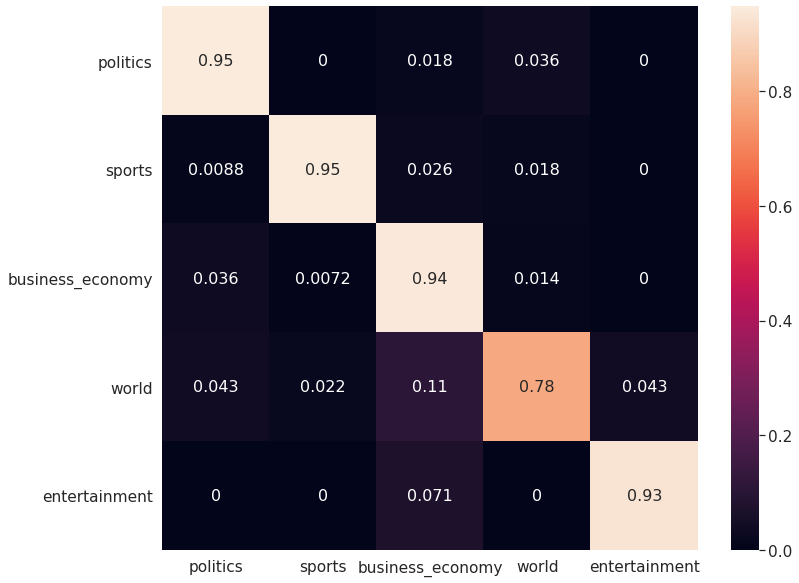

In [30]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
plt.figure(figsize = (12,10))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16})

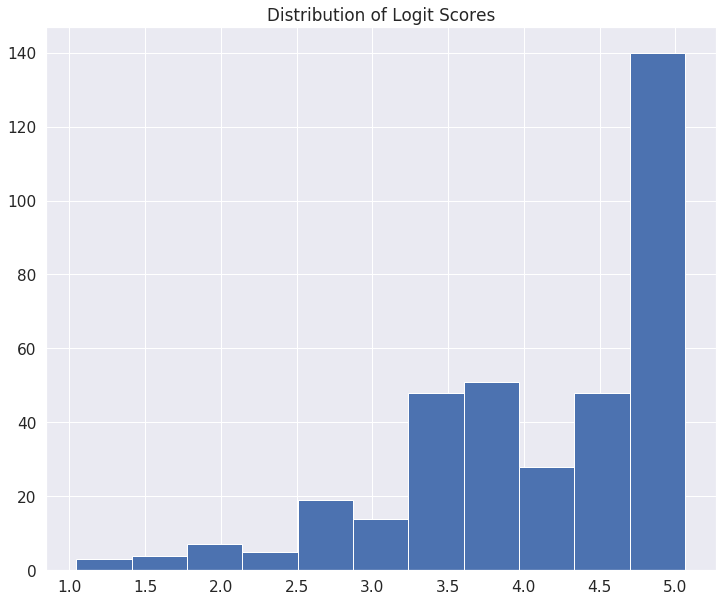

In [31]:
plt.figure(figsize=(12,10))
_ = plt.hist(maxes, bins='auto')  # arguments are passed to np.histogram
plt.title("Distribution of Logit Scores")
plt.show()


## Results

Are looking very well. We miss mostly on the World News which is reasonable as World News could be Political or Sports etc. 

## 7. Predicting Unlabeled Cases

We will have to get through the same Prep process

In [32]:
test_examples = processor.get_test_examples(model_input_folder)
examples = [(example, label_map, max_seq_length, tokenizer, output_mode, pad_on_the_left,
                     pad_token, pad_token_segment_id, mask_padding_with_zero)
                    for example in test_examples]

In [33]:
with Pool(processor_count) as proc:
    features = list(tqdm(proc.imap(convert_example_to_feature, examples), total=len(test_examples)))

In [41]:
test_data = convert_to_tensors(features, 'test')
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=256)

In [49]:
# Initialize variables
nb_eval_steps = 0
preds = None
results = {}
out_label_ids = None

logger.info(f"***** Evaluating...*****")
logger.info(f"  Num examples = {len(test_data)}")
logger.info(f"  Batch size = {256}")

# Evaluate dev 
for batch in tqdm(test_dataloader, desc="Evaluating..."):
    model.eval()
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    with torch.no_grad():
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1]}
        if model_type != 'distilbert':
            inputs['token_type_ids'] = batch[2] if model_type in ['bert', 'xlnet'] else None
        # Forward pass, calculate logit predictions
        outputs = model(**inputs)
        logits = outputs[0]
        
    nb_eval_steps += 1

    if preds is None:
        preds = logits.detach().cpu().numpy()
    else:
        preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)


2020-01-10 14:16:58.063 | INFO     | __main__:<module>:7 - ***** Evaluating...*****
2020-01-10 14:16:58.064 | INFO     | __main__:<module>:8 -   Num examples = 159764
2020-01-10 14:16:58.065 | INFO     | __main__:<module>:9 -   Batch size = 256


## 8. Merging it all with the original dataset

In [60]:
df = pd.read_csv(model_input_folder / 'all_data.csv')

In [65]:
# Label Index
label_ix = {v:k for k,v in label_map.items()}

In [66]:
df.loc[df.kw_label.isna(), 'y_pred'] = [label_ix[i]  for i in y_pred]

In [70]:
# Make sure we have the same records
len(train_data) + len(dev_data) == df[~df.kw_label.isna()].shape[0]

True

In [71]:
len(test_data) == df[df.kw_label.isna()].shape[0]

True

In [74]:
# Convert Logits to Probabilities with Softmax
m = nn.Softmax(dim=-1)
dat = torch.Tensor(preds)
probs  = m(dat)
probs = probs.numpy()

In [76]:
df.loc[df.kw_label.isna(),'proba'] = np.max(probs, axis=1)

In [77]:
df.head()

,url,dom_cat,title,description,keywords,news_keywords,text,kw_label,y_pred,proba
0,https://chicago.cbslocal.com/2019/12/18/man-st...,sports,Man Stabbed After His Granddaughter And Three ...,A man's granddaughter is one of four teens acc...,"grandfather, granddaughter, teen, teens, home ...","grandfather, granddaughter, teen, teens, home ...",Man Stabbed After His Granddaughter And Three ...,NaN,entertainment,0.919803
1,http://www.releasewire.com/press-releases/rele...,news,Commence Industrial CRM Achieves Sales Optimiz...,NaN,NaN,NaN,Commence Industrial CRM Achieves Sales Optimiz...,NaN,business_economy,0.985866
2,https://www.kark.com/news/national-news/1-dead...,news,"1 dead, 2 injured in Oregon shopping center st...",Multiple people were stabbed at the Murray Hil...,NaN,NaN,"1 dead, 2 injured in Oregon shopping center st...",NaN,business_economy,0.515074
3,https://www.ii.co.uk/etfs/sg-wti-x2-daily-long...,financial_news,LSE:SG30 ETF Share Price | SG WTI X2 Daily Lon...,Real-time share price updates and latest news ...,NaN,NaN,LSE:SG30 ETF Share Price | SG WTI X2 Daily Lon...,NaN,business_economy,0.985905
4,http://www.peicanada.com/island_deaths/frances...,news,Frances Salsman | Island Deaths | peicanada.com,"SALSMAN, Frances (Fran) Townsend At the Prince...","island_deaths, death_notices","island_deaths, death_notices",Frances Salsman | Island Deaths | peicanada.co...,NaN,sports,0.429380


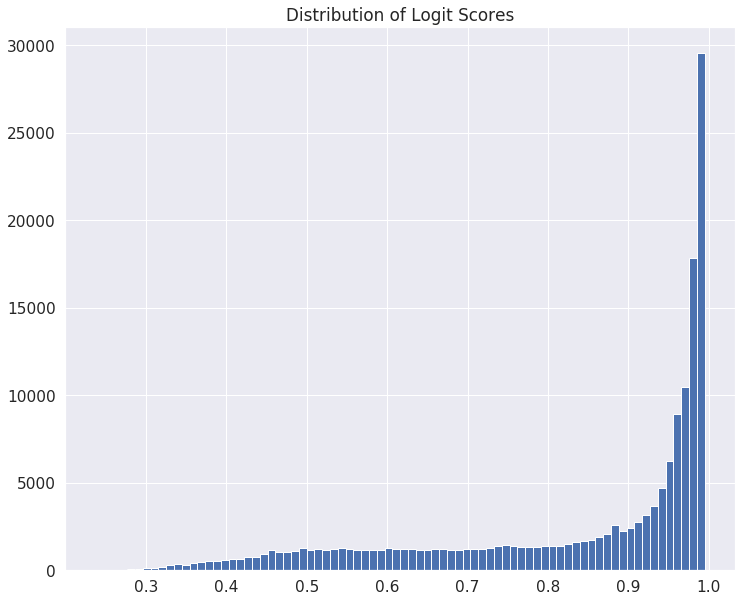

In [78]:
plt.figure(figsize=(12,10))
_ = plt.hist(np.max(probs, axis=1), bins='auto')  # arguments are passed to np.histogram
plt.title("Distribution of Logit Scores")
plt.show()


## 9. Subsetting the dataset for the next Topic modeling exercise

What we intend to do here is to subset the whole set for when we have either "true or handlabeled labels" or any predicted document to have at least 0.90 probability of falling into a class. 

In [8]:
np.floor(df.proba.quantile(0.2)*100)/100

NameError: name 'df' is not defined

In [88]:
len(df[(df.kw_label.isna()) & (df.proba>=0.9)]) / len(df[df.kw_label.isna()])

0.558392378758669

We get about 0.55% of all records

In [97]:
df.y_pred.unique()

array(['entertainment', 'business_economy', 'sports', 'politics', 'world',
       nan], dtype=object)

In [101]:
# Sampling from each class for some inspection
for c in df[~df.y_pred.isna()].y_pred.unique():
    print(c)
    print("-"*100)
    for t in df[(df.kw_label.isna()) & (df.proba>=0.9) & (df.y_pred == c)].sample(3).text:
        print(t)
    print("*"*100)

entertainment
----------------------------------------------------------------------------------------------------
A Christmas Miracle Play with Nataliya Molsbee - One News Page VIDEO Global One News PageCelebrating 10 Years of Trusted News Discovery HOMEWORLDSPORTSPOLITICSBUSINESSPEOPLESCITECHTop Stories • Video • Live TVMovie ReviewsMost PopularFront Page NewsLatest One News Page > News Videos > A Christmas Miracle Play with Nataliya Molsbee A Christmas Miracle Play with Nataliya Molsbee Video Credit: WXXV - Published 10 hours ago< > Embed A Christmas Miracle Play with Nataliya Molsbee 0sharesShareTweetSavePostSend A Christmas Miracle Play with Nataliya Molsbee- it's not too late to catch a- christmas miracle this- holiday season! - natliya molsbee joins us now in- our studio to tell us all about- how she and her students are- bringing a christmas- miracle to life right here in - south mississippi!- - wxxv >> the students associate of participating in this concert. Can you tell me al

In [ ]:
# Create a single Label class and call it Main Topic
def concat_labels (kw_label, y_pred):
    if y_pred:
        return y_pred

In [113]:
df['main_topic'] = df.apply(lambda row: row['y_pred'] if row['kw_label'] is np.nan else row['kw_label'], axis=1)

In [117]:
df.head()

,url,dom_cat,title,description,keywords,news_keywords,text,kw_label,y_pred,proba,main_topic
0,https://chicago.cbslocal.com/2019/12/18/man-st...,sports,Man Stabbed After His Granddaughter And Three ...,A man's granddaughter is one of four teens acc...,"grandfather, granddaughter, teen, teens, home ...","grandfather, granddaughter, teen, teens, home ...",Man Stabbed After His Granddaughter And Three ...,NaN,entertainment,0.919803,entertainment
1,http://www.releasewire.com/press-releases/rele...,news,Commence Industrial CRM Achieves Sales Optimiz...,NaN,NaN,NaN,Commence Industrial CRM Achieves Sales Optimiz...,NaN,business_economy,0.985866,business_economy
2,https://www.kark.com/news/national-news/1-dead...,news,"1 dead, 2 injured in Oregon shopping center st...",Multiple people were stabbed at the Murray Hil...,NaN,NaN,"1 dead, 2 injured in Oregon shopping center st...",NaN,business_economy,0.515074,business_economy
3,https://www.ii.co.uk/etfs/sg-wti-x2-daily-long...,financial_news,LSE:SG30 ETF Share Price | SG WTI X2 Daily Lon...,Real-time share price updates and latest news ...,NaN,NaN,LSE:SG30 ETF Share Price | SG WTI X2 Daily Lon...,NaN,business_economy,0.985905,business_economy
4,http://www.peicanada.com/island_deaths/frances...,news,Frances Salsman | Island Deaths | peicanada.com,"SALSMAN, Frances (Fran) Townsend At the Prince...","island_deaths, death_notices","island_deaths, death_notices",Frances Salsman | Island Deaths | peicanada.co...,NaN,sports,0.429380,sports


In [134]:
df_topic_ready = df.loc[(df.proba >=0.9) | (~df.kw_label.isna()), ['url', 'text', 'main_topic']].copy()
df_topic_ready.reset_index(drop=True, inplace=True)

In [135]:
df_topic_ready

,url,text,main_topic
0,https://chicago.cbslocal.com/2019/12/18/man-st...,Man Stabbed After His Granddaughter And Three ...,entertainment
1,http://www.releasewire.com/press-releases/rele...,Commence Industrial CRM Achieves Sales Optimiz...,business_economy
2,https://www.ii.co.uk/etfs/sg-wti-x2-daily-long...,LSE:SG30 ETF Share Price | SG WTI X2 Daily Lon...,business_economy
3,http://www.sbwire.com/press-releases/syndeo-co...,Syndeo Communications Invites the San Diego Bu...,business_economy
4,https://www.theverge.com/2019/12/18/21028416/a...,AT&T will now show you a green check mark for ...,business_economy
...,...,...,...
92875,https://www.yourerie.com/news/newsmaker/newsma...,Newsmaker- Monsignor Ed Lohse | WJET/WFXP/Your...,sports
92876,https://www.trtworld.com/life/researchers-say-...,Researchers say may have found cause of mad co...,business_economy
92877,https://www.bakingbusiness.com/articles/49996-...,Dairy Farmers of America merges ingredients bu...,business_economy
92878,https://www.thehollywoodgossip.com/slideshows/...,90 Day Fiance Before The 90 Days: Trailer Teas...,entertainment


## 10. Saving the results 

In [138]:
out_path = Path.home() / 'Data' / 'cc_news' / 'model_output'
if not out_path.is_dir():
    Path.mkdir(out_path, parents=True, exist_ok=True)    

In [139]:
df_topic_ready.to_csv(out_path / 'data_topic_model_ready.csv', header=True, index=False)

# End of Notebook

Wow... 
1. We have created our features in a parallel format, 
2. fine tuned a decent BERT classifier that does pretty good on the documents
3. then extracted some records to be used in Topic Modeling 